In [130]:
import sys
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from pathlib import Path

sys.path.append('../src/')
from bonsai import load_bonsai_config
load_bonsai_config(r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging\Bonsai")
import harp
import harp.processing as hp
from harp import SoftwareEventCollection

sns.set_style("whitegrid")

In [123]:
# Main path for all the data
path = r"Z:\vr-foraging\672107\20230925T114601"

In [ ]:
# REcover data streams from the AnalogInput and Behavior board. Good for discrete data. 
HarpBehavior = harp.Device("Behavior")
AnalogInput = harp.Device("AnalogInput")

## Paths to the data:
root = Path(path)
fname_formatter = lambda reg : f"Register__{reg}.bin"
# Harp.Behavior data:
harp_behavior_root = root / "Behavior"

# Harp.AnalogInput data:
harp_analog_root = root /  "Analog"

# SoftwareEvents data:
SoftwareEvents_root = root /  "SoftwareEvents"

In [ ]:
# Load the Analog input data. 
encoder  = harp.read_harp_bin(harp_behavior_root / fname_formatter("AnalogData"))
perimeter = 15*np.pi
resolution = perimeter / -8192
encoder['velocity'] = (encoder[1] * resolution)*1000

In [ ]:
##Load digital output data
digital_output_onset = HarpBehavior.file_to_dataframe(harp_behavior_root / fname_formatter("OutputSet"))
digital_output_offset = HarpBehavior.file_to_dataframe(harp_behavior_root / fname_formatter("OutputClear"))

digital_outputs = HarpBehavior.module.DigitalOutputs

water_state = digital_output_onset.loc[digital_output_onset["Value"] == digital_outputs.SupplyPort0]
odor1_state = hp.distinct_until_changed_state(digital_output_onset, digital_output_offset, digital_outputs.SupplyPort1)
odor2_state = hp.distinct_until_changed_state(digital_output_onset, digital_output_offset, digital_outputs.SupplyPort2)


In [124]:
# Recover software events for sites
softwareEvents = path + "\SoftwareEvents\ActiveSite.json"
ActiveSite = SoftwareEventCollection.from_json_file(softwareEvents)

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\vr-foraging\\672107\\20230925T114601\\SoftwareEvents\\ActiveSite.json'

In [128]:
values_list = []
start_position = []

# Loop through the DataFrame and access the dictionary values for label and start position. 
for index, row in ActiveSite.table.iterrows():
    cell_value = row['data']
    values_list.append(cell_value['label'])
    start_position.append(cell_value['startPosition'])

df = pd.DataFrame(values_list, columns = ['label'])
df['Seconds'] = ActiveSite.table['Seconds'] 
df['startPosition'] = start_position


### Old way of plotting the data

In [119]:
path = r"Z:\vr-foraging\672107\20230920T125148\Behavior\Register__"

In [118]:

df  = harp.read_harp_bin(path+str(44)+".bin")
perimeter = 15*np.pi
resolution = perimeter / -8192
df['velocity'] = (df[1] * resolution)*1000

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\vr-foraging\\672107\\20230920T125148\\Behavior\\Register__44.bin'

In [17]:
odor_df  = harp.read_harp_bin(path+str(34)+".bin")


In [18]:
water_on = harp.read_harp_bin(path+str(34)+".bin")
water_on = water_on.loc[water_on['Value'] & 0x08 > 0] * 0 + 1
water_off = harp.read_harp_bin(path+str(35)+".bin")
water_off = water_off.loc[water_off['Value'] & 0x08 > 0] * 0
water = pd.concat([water_on, water_off], join='outer', sort=True)


In [19]:
odor1_on = harp.read_harp_bin(path+str(34)+".bin")
odor1_on = odor1_on.loc[odor1_on['Value'] & 16 > 0] * 0 + 1
odor1_off = harp.read_harp_bin(path+str(35)+".bin")
odor1_off = odor1_off.loc[odor1_off['Value'] & 16 > 0] * 0
odor1 = pd.concat([odor1_on, odor1_off], join='outer').sort_index()
odor1 = odor1.loc[odor1.Value.diff() != 0]

In [ ]:
# // calculate running window for velocity in df
def running_average(numbers, window_size):
    if window_size <= 0:
        raise ValueError("Window size must be greater than 0")
    
    running_averages = []
    window_sum = 0
    
    for i, num in enumerate(numbers):
        window_sum += num
        
        if i >= window_size - 1:
            average = window_sum / window_size
            running_averages.append(average)
            window_sum -= numbers[i - window_size + 1]
    
    return running_averages

In [20]:
#------------------------------------------------
# Create a FIR filter and apply it to signal.
#------------------------------------------------
# The Nyquist rate of the signal.
from scipy.signal import lfilter, firwin
nyq_rate = 1000 / 2.

# The cutoff frequency of the filter: 6KHz
cutoff_hz = 5.0

# Length of the filter (number of coefficients, i.e. the filter order + 1)
numtaps = 61

# Use firwin to create a lowpass FIR filter
fir_coeff = firwin(numtaps, cutoff_hz/nyq_rate)

# Use lfilter to filter the signal with the FIR filter
df["filtered_velocity"] = lfilter(fir_coeff, 1.0, df["velocity"].values)



KeyError: 'filtered_velocity'

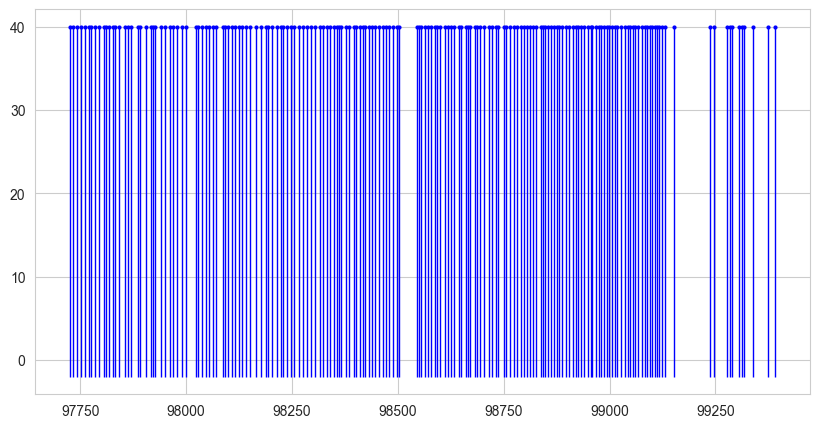

In [131]:

plt.figure(figsize=(10, 5))

# plt.plot(odor1.loc[odor1.Value == 1].index,  np.repeat(40, len(odor1.loc[odor1.Value == 1])),  marker='x', linestyle='none', markersize=5, color='crimson')
# plt.vlines(odor1.loc[odor1.Value == 1].index, ymin=-2, ymax=40, color='crimson', linewidth=1)

# plt.plot(odor1.loc[odor1.Value == 0].index,  np.repeat(40, len(odor1.loc[odor1.Value == 0])),  marker='x', linestyle='none', markersize=5, color='pink')
# plt.vlines(odor1.loc[odor1.Value == 0].index, ymin=-2, ymax=40, color='pink', linewidth=1)

plt.plot(water.index,  np.repeat(40, len(water)),  marker='o', linestyle='none', markersize=2, color='blue')
plt.vlines(water.index, ymin=-2, ymax=40, color='blue', linewidth=1)

plt.plot(df.index.values, df["filtered_velocity"], color='black')
plt.xlim(98963, 98995)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')

# Shade the background
plt.axvspan(98963.7, 98950.7, alpha=0.2, color='grey', label='Shaded Area')
plt.axvspan(98966.7, 98971.5, alpha=0.2, color='grey', label='Shaded Area')
plt.axvspan(98972.7, 98977.5, alpha=0.2, color='grey', label='Shaded Area')
plt.axvspan(98979.2, 98984.0, alpha=0.2, color='grey', label='Shaded Area')
plt.axvspan(98985.3, 98990.4, alpha=0.2, color='grey', label='Shaded Area')
plt.axvspan(98991.8, 98995.4, alpha=0.2, color='grey', label='Shaded Area')


sns.despine()
# Define custom tick positions and labels for the x-axis
custom_xticks = [98963, 98967, 98972, 98977, 98982, 98987, 98992, 98997]
custom_xtick_labels = [0, 5, 10, 15, 20,25,30,35]
# Set custom ticks and labels for the x-axis
plt.xticks(custom_xticks, custom_xtick_labels)
plt.ylim(-3,41)
plt.savefig('672107.png', dpi=300, bbox_inches='tight')

In [ ]:
import json

# //load json file
with open(r'D:\672107\20230920T125148\config.json') as f:
  data = json.load(f)

In [ ]:
path

In [ ]:
import json

# //load json file
with open(r'Z:\vr-foraging\672107\20230925T114601\SoftwareEvents\ChoiceFeedback.json') as f:
  data = json.load(f)

In [ ]:
df['time_intervals']= df.index.diff()
df.fillna(0.001, inplace=True)
df

In [ ]:
def calculate_distance(speeds, time_intervals):
    if len(speeds) != len(time_intervals):
        raise ValueError("Length of speeds and time_intervals must be the same")

    distance = 0.0

    for i in range(len(speeds)):
        delta_t = time_intervals[i]
        v = speeds[i]
        distance += v * delta_t

    return distance

# Example usage:
speeds = df["velocity"].values  # Instantaneous speeds in m/s
time_intervals = df['time_intervals'].values  # Time intervals in seconds

total_distance = calculate_distance(speeds, time_intervals)
print(f"Total distance traveled: {total_distance} meters")


In [ ]:

def calculate_instantaneous_positions(speeds, time_intervals):
    if len(speeds) != len(time_intervals):
        raise ValueError("Length of speeds and time_intervals must be the same")

    positions = [0.0]  # Initialize with an initial position of 0
    for i in range(len(speeds)):
        delta_t = time_intervals[i]
        v = speeds[i]
        position = positions[-1] + v * delta_t
        positions.append(position)
    
    return positions[1:]

# Example usage:
speeds = df["velocity"].values  # Instantaneous speeds in m/s
time_intervals = df['time_intervals'].values  # Time intervals in seconds

instantaneous_positions = calculate_instantaneous_positions(speeds, time_intervals)
print("Instantaneous positions (meters):", instantaneous_positions)
df['instantaneous_positions'] = instantaneous_positions

In [ ]:
pd.concat([odor1,df]).sort_index()

In [ ]:
plt.plot(df['instantaneous_positions'], df['filtered_velocity'], color='black')

plt.plot(odor1.loc[odor1.Value == 1].index,  np.repeat(40, len(odor1.loc[odor1.Value == 1])),  marker='x', linestyle='none', markersize=5, color='crimson')
plt.vlines(odor1.loc[odor1.Value == 1].index, ymin=-10, ymax=40, color='crimson', linewidth=1)

plt.plot(odor1.loc[odor1.Value == 0].index,  np.repeat(40, len(odor1.loc[odor1.Value == 0])),  marker='x', linestyle='none', markersize=5, color='pink')
plt.vlines(odor1.loc[odor1.Value == 0].index, ymin=-10, ymax=40, color='pink', linewidth=1)

plt.plot(water.index,  np.repeat(40, len(water)),  marker='o', linestyle='none', markersize=2, color='blue')
plt.vlines(water.index, ymin=-10, ymax=40, color='blue', linewidth=1)

plt.xlim(1500, 1700)
sns.despine()
plt.xlabel("Distance(cm)")
plt.ylabel("Spped(cm/s)")